In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import scipy.io
import tarfile

In [3]:
# Ensure TensorFlow uses the GPU if available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Available devices:", tf.config.experimental.list_physical_devices())

Num GPUs Available:  1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Path to the .tgz file
tgz_path = '/kaggle/input/102flowers/102flowers.tgz'

# Extract the .tgz file
with tarfile.open(tgz_path, 'r:gz') as tar:
    tar.extractall(path='/kaggle/working/flower_images')

In [5]:
# Load the .mat files
imagelabels = scipy.io.loadmat('/kaggle/input/102flowers/imagelabels.mat')

In [6]:
image_dir = '/kaggle/working/flower_images/jpg'
labels = imagelabels['labels'][0] - 1  # Adjusting to zero-based indexing

# Get the image file names
image_files = sorted(os.listdir(image_dir))

# Prepare a list of file paths and corresponding labels
file_paths = [os.path.join(image_dir, f'image_{i+1:05d}.jpg') for i in range(len(image_files))]
labels = labels.astype(str)

# Create a dataframe for easy manipulation
data = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_data, x_col='file_path', y_col='label', target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_dataframe(val_data, x_col='file_path', y_col='label', target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [8]:
# Use pre-trained weights from the internet
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [9]:
num_classes = len(train_generator.class_indices)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Add dropout to prevent overfitting
    Dense(num_classes, activation='softmax')
])

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
epochs = 32
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

Epoch 1/32


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722069712.496270     681 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722069712.589557     681 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.0270 - loss: 5.0503

W0000 00:00:1722069831.485800     681 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


205/205 ━━━━━━━━━━━━━━━━━━━━ 203s 620ms/step - accuracy: 0.0271 - loss: 5.0489 - val_accuracy: 0.0031 - val_loss: 6.2588
Epoch 2/32
205/205 ━━━━━━━━━━━━━━━━━━━━ 87s 409ms/step - accuracy: 0.1918 - loss: 3.7156 - val_accuracy: 0.0171 - val_loss: 5.6511
Epoch 3/32
205/205 ━━━━━━━━━━━━━━━━━━━━ 86s 405ms/step - accuracy: 0.4196 - loss: 2.6444 - val_accuracy: 0.1007 - val_loss: 4.2730
Epoch 4/32
205/205 ━━━━━━━━━━━━━━━━━━━━ 86s 406ms/step - accuracy: 0.5645 - loss: 1.9599 - val_accuracy: 0.5531 - val_loss: 2.0238
Epoch 5/32
205/205 ━━━━━━━━━━━━━━━━━━━━ 86s 407ms/step - accuracy: 0.6799 - loss: 1.4482 - val_accuracy: 0.8132 - val_loss: 0.8780
Epoch 6/32
205/205 ━━━━━━━━━━━━━━━━━━━━ 87s 408ms/step - accuracy: 0.7733 - loss: 1.0558 - val_accuracy: 0.8810 - val_loss: 0.5571
Epoch 7/32
205/205 ━━━━━━━━━━━━━━━━━━━━ 86s 404ms/step - accuracy: 0.8180 - loss: 0.8080 - val_accuracy: 0.9078 - val_loss: 0.4217
Epoch 8/32
205/205 ━━━━━━━━━━━━━━━━━━━━ 84s 396ms/step - accuracy: 0.8668 - loss: 0.6033 - va

In [11]:
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9719 - loss: 0.1057
Validation Accuracy: 97.37%


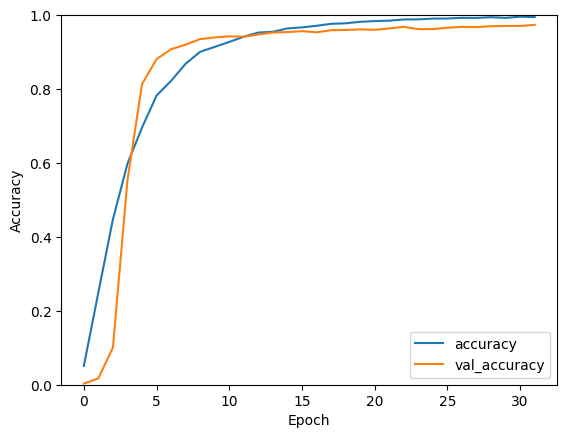

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()